In [57]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm 
from skimage import data, img_as_float
from skimage import exposure
from skimage.io import imread, imshow, imsave
from skimage.draw import polygon2mask
from skimage.transform import resize
import matplotlib.pyplot as plt
from model import Unet_model

In [15]:
# Rutas de las carpetas de imágenes y máscaras
dir_img = os.getcwd() + "/dataset/img"
dir_mask = os.getcwd() + "/dataset/mask"

image_files = sorted([os.path.join(dir_img, f) for f in os.listdir(dir_img)])
mask_files = sorted([os.path.join(dir_mask, f) for f in os.listdir(dir_mask)])
padds = [[94, 94], [94, 94], [0, 0]]
imgs = ["191", "276", "054","703"]

IMAGEN


/home/kenetc/tf/lib/python3.10/site-packages/skimage/_shared/utils.py:445: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


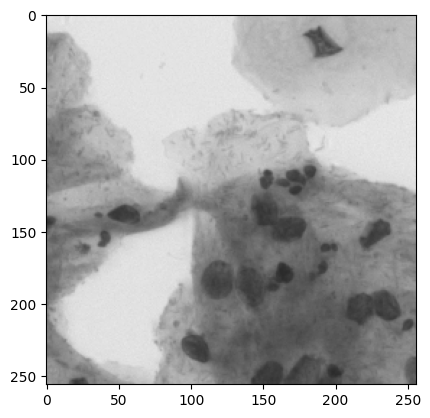

adap eq


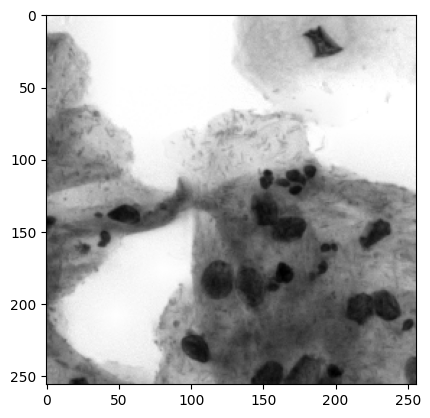

/home/kenetc/tf/lib/python3.10/site-packages/skimage/_shared/utils.py:445: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


IMAGEN


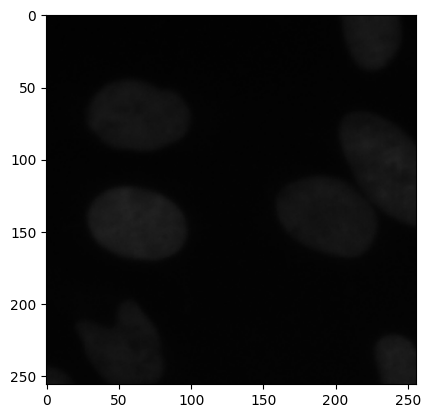

adap eq


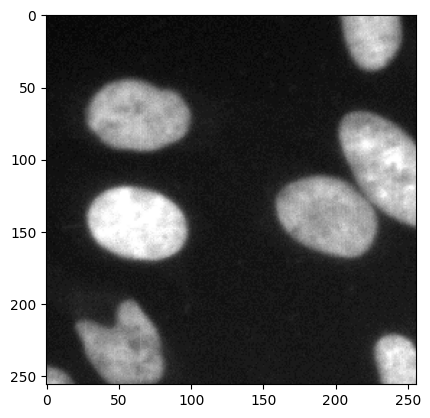

/home/kenetc/tf/lib/python3.10/site-packages/skimage/_shared/utils.py:445: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


IMAGEN


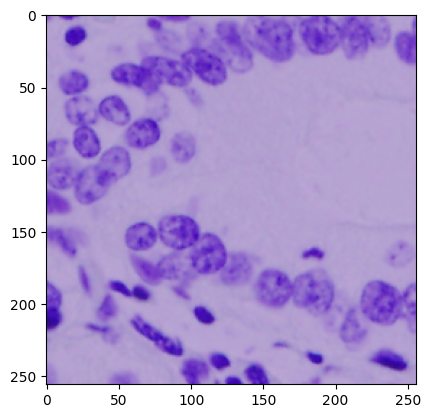

adap eq


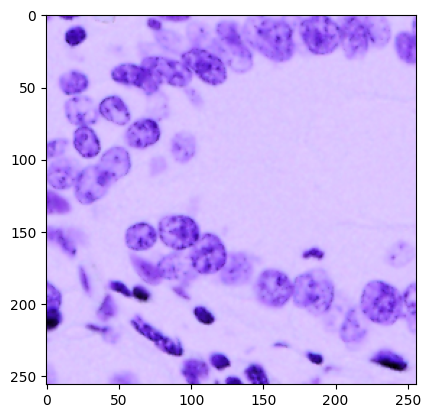

IMAGEN


/home/kenetc/tf/lib/python3.10/site-packages/skimage/_shared/utils.py:445: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


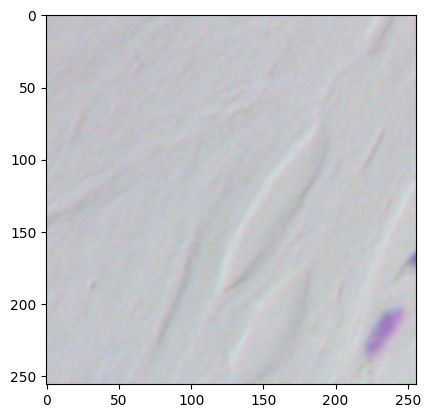

adap eq


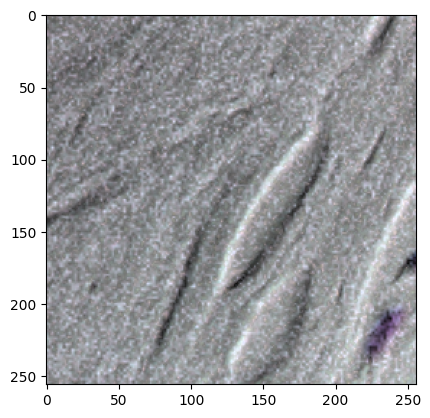

In [114]:
for n in imgs: 
    img = imread(dir_img + f'/img_{n}.png')
    img_eq = exposure.equalize_hist(img)
    img_adapteq = exposure.equalize_adapthist(img, clip_limit = 0.005)
    print("IMAGEN")
    plt.imshow(img)
    plt.show()
    print('adap eq')
    plt.imshow(img_adapteq)
    plt.show()

In [68]:
# Aplicar skimage.exposure.equalize_adapthist usando tf.py_function
def equalize_adapthist(img, c:float= 0.005):
    '''
    img : type tensorflow.image
    '''
    img_np = (img.numpy()).astype(np.uint8) 
    equalized_img = exposure.equalize_adapthist(img_np, clip_limit=c)
    return equalized_img.astype(np.float32) 

# Función para cargar y preprocesar una imagen y máscara
def load_and_preprocess(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  
    
    image = tf.py_function(equalize_adapthist, inp=[image], Tout=tf.float32)
    # image = tf.cast(image, tf.float32) / 255.0
    image = tf.pad(image, paddings = padds, mode = "REFLECT")
    image.set_shape([444, 444, 3])

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0  

    return image, mask

# Crear el dataset
dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))
dataset = dataset.map(load_and_preprocess)

(444, 444, 3)


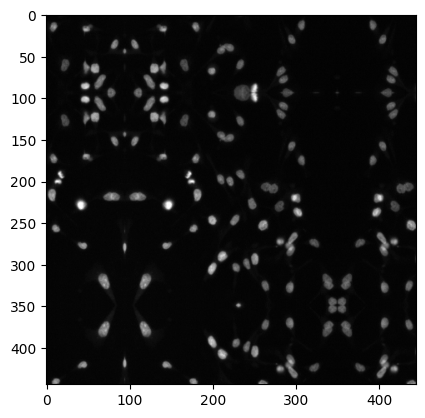

2025-04-03 00:19:06.870345: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [71]:
for img,mask in dataset.take(1): 
    # img = (img.numpy() * 255).astype(np.uint8)
    print((img.numpy()).shape)
    plt.imshow(img)
    plt.show()

In [111]:
N = 256 + 2*94
nm = Unet_model(N, N, 3, base = 8)
input_shape = (1,N, N, 3)
dummy_input = tf.random.normal(shape=input_shape)

# Construir el modelo llamándolo con los datos ficticios
nm(dummy_input)

<tf.Tensor: shape=(1, 256, 256, 1), dtype=float32, numpy=
array([[[[0.71370214],
         [0.44430095],
         [0.5870674 ],
         ...,
         [0.43592566],
         [0.6435763 ],
         [0.54936737]],

        [[0.3109163 ],
         [0.4734502 ],
         [0.36913052],
         ...,
         [0.362556  ],
         [0.30850792],
         [0.33514205]],

        [[0.50218076],
         [0.47561327],
         [0.6224691 ],
         ...,
         [0.53665775],
         [0.5606115 ],
         [0.48059958]],

        ...,

        [[0.33099976],
         [0.39776757],
         [0.27568638],
         ...,
         [0.47097716],
         [0.28285432],
         [0.48575613]],

        [[0.39043808],
         [0.45500892],
         [0.6411458 ],
         ...,
         [0.5352929 ],
         [0.5905566 ],
         [0.27133733]],

        [[0.23651487],
         [0.5382881 ],
         [0.27740824],
         ...,
         [0.47163814],
         [0.11771697],
         [0.43270653]]]], dty

In [112]:
nm.load_weights('Pmodel.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predict


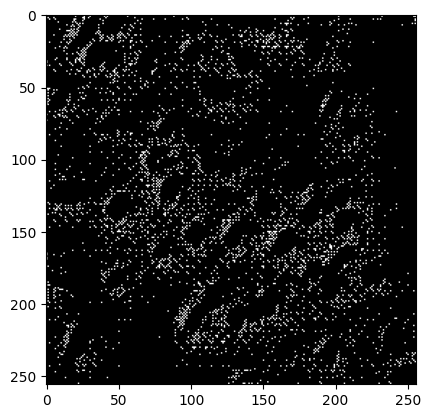

mask


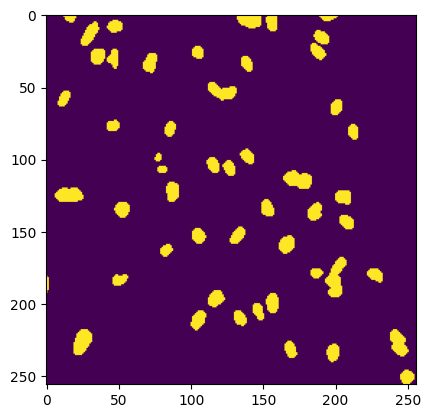

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predict


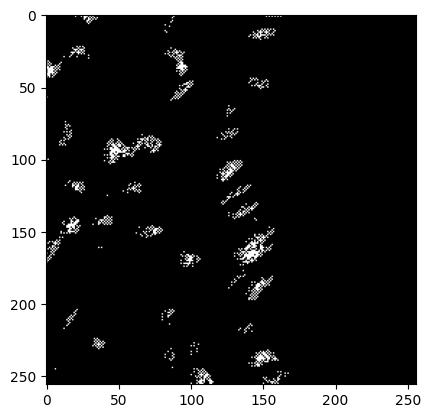

mask


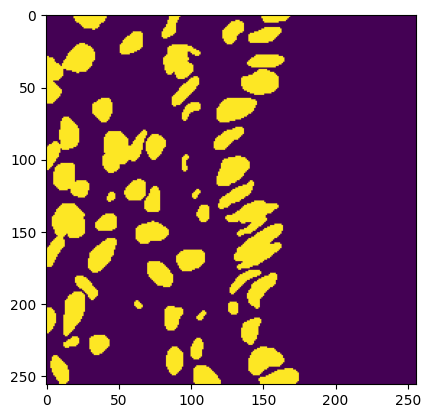

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
predict


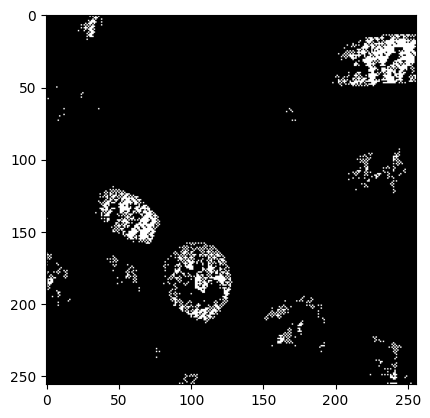

mask


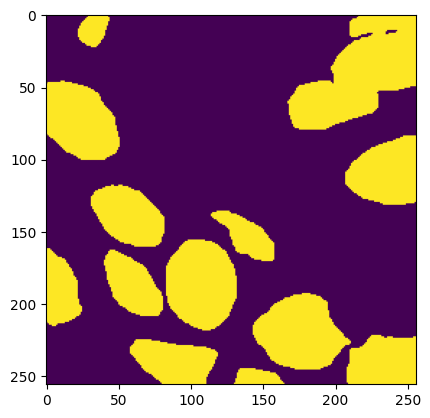

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predict


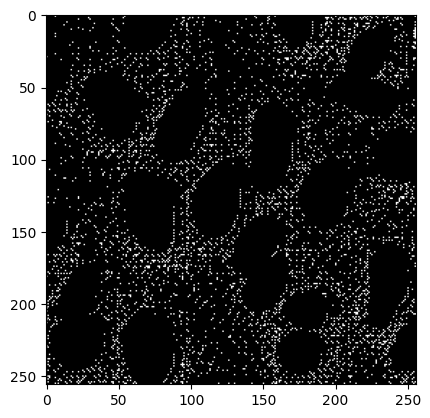

mask


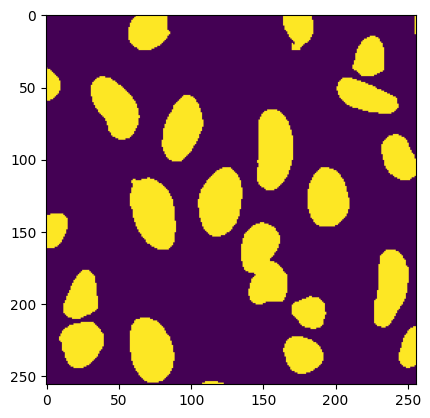

2025-04-03 03:04:20.399258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [113]:
for img, mask in dataset.take(4):
    img = tf.expand_dims(img, axis=0)
    res = m.predict(img)
    res = np.squeeze(res[0]>0.5)
    # print(np.unique(res))
    print("predict")
    plt.imshow(res, cmap='gray')
    plt.show()
    print("mask")
    plt.imshow(mask)
    plt.show()
    # break

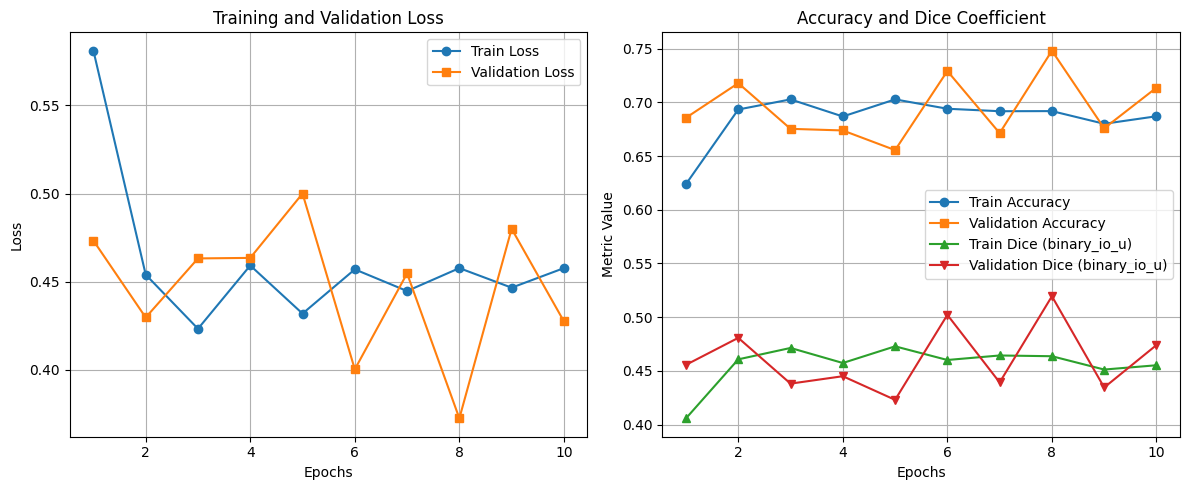

In [123]:
# Datos del entrenamiento
epochs = list(range(1, 11))
train_loss = [0.5810, 0.4540, 0.4233, 0.4592, 0.4319, 0.4570, 0.4447, 0.4577, 0.4466, 0.4577]
val_loss = [0.4733, 0.4297, 0.4632, 0.4635, 0.5000, 0.4003, 0.4547, 0.3725, 0.4800, 0.4275]
train_accuracy = [0.6239, 0.6933, 0.7027, 0.6868, 0.7027, 0.6940, 0.6917, 0.6918, 0.6800, 0.6870]
val_accuracy = [0.6856, 0.7178, 0.6753, 0.6738, 0.6555, 0.7291, 0.6713, 0.7480, 0.6758, 0.7136]
train_dice = [0.4059, 0.4608, 0.4714, 0.4574, 0.4729, 0.4602, 0.4644, 0.4637, 0.4513, 0.4553]
val_dice = [0.4557, 0.4808, 0.4382, 0.4451, 0.4231, 0.5022, 0.4393, 0.5195, 0.4346, 0.4741]

# Graficar Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()

# Graficar Accuracy y Dice
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='s')
plt.plot(epochs, train_dice, label='Train Dice (binary_io_u)', marker='^')
plt.plot(epochs, val_dice, label='Validation Dice (binary_io_u)', marker='v')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Accuracy and Dice Coefficient')
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig("training_metrics.png") 
plt.show()